# MLP on MNIST + Position Shift

This notebook is similar to the previous notebooks where we applied MLP/CNN on MNIST dataset. What's new is that we look into how MLP performs when the digit's position is shifted (in both vertical and horizontal direction).

## Goal
1. Prepare MNIST dataset with position shift.
2. Train MLP and CNN on MNIST digit images without a shift. 
3. Run the inference on the test dataset with translational shift. 
4. Try two more combinations of (train,test) = (shifted,shifted) and (shifted,no shift).

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

### Note: `mnist_utils.py` module
For this notebook, `mnist_utils.py` is prepared with handy functions. We will go over those functions briefly (+in details if requested!) but they are helpers and do not concern the core contents of programming ML components.

## 1. Prepare dataset

Let's load MNIST dataset. You might have noticed that the MNIST dataset constructor can take a `transform` argument, which can be a composite of functions to be run upon preparing a dataset. This is handy: we already used a function to convert, automatically, image data into Pytorch tensor using `transforms.ToTensor()`. This time we also add what's called `mnist_utils.ImagePadder` that pads the MNIST 28x28 pixels images +N pixels in all ways (so it's (28+N)x(28+N) pixels). The constructor of `mnist_utils.ImagePadder` takes a boolean flag called `randomize` which then shifts the location of a digit within the padded image space.

We prepare dataset and dataloader for both train and test samples.

In [2]:
from torchvision import datasets, transforms
from mnist_utils import ImagePadder
# Data file download directorymnist_utils
LOCAL_DATA_DIR = './mnist-data'
# Prepare train data
train_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                               transform=transforms.Compose([ImagePadder(randomize=False),transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
# Prepare test data
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([ImagePadder(randomize=True),transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=2,pin_memory=True)

### Exercise 1

Play with the dataset and figure out how many pixels we have padded (i.e. what's the image size?).

In [ ]:
# your code

### Visualizing data

I prepared another function that can visualize a list of classes and image. Let's visualize both train and test dataset. You should not see a shift for the train dataset, but the test dataset should show shifted locations.

Train dataset


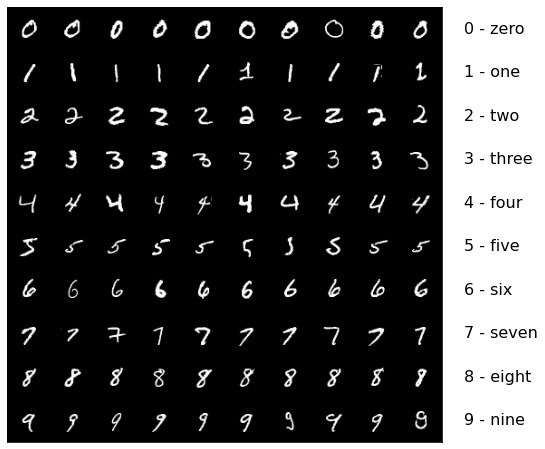

Test dataset


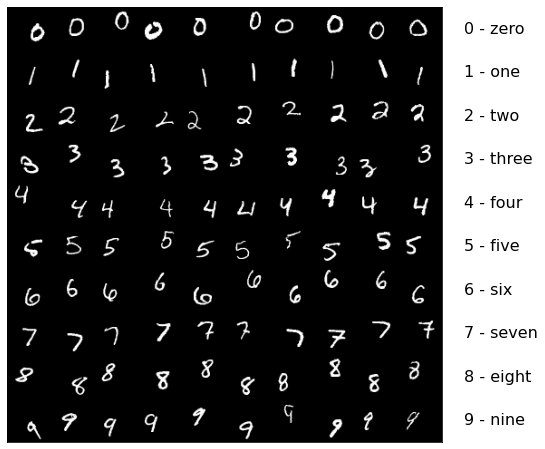

In [4]:
# Visualize classes
from mnist_utils import plot_dataset
print('Train dataset')
plot_dataset(train_dataset)
print('Test dataset')
plot_dataset(test_dataset)

<a href="network"></a>
## 2. Train MLP and CNN on MNIST with no shift

Let's define MLP and MNIST and train!

### Exercise 2
Design MNIST and CNN the same way we did in the last notebook. Yes, that means you can _pretty much_ copy and paste, or you can practice trying to write from scratch :) I add a few required specifications below.

* The model's constructor should take 2 optional arguments with default values: `image_size=48` and `num_filters=`16`.
* MLP should have 2 `torch.nn.Linear` layers with `torch.nn.LeakyReLU` in between.
* CNN should have 3 `torch.nn.Conv2d` layers followed by `torch.nn.LeakyReLU` and `torch.nn.MaxPool2d`
  * Use the kernel size of 3 and stride 1 for the convolution layers
  * Use the kernel size of 2 and stride 2 for pooling layers
  * The number of filters in the first convolution layer should be `num_filters`, then it should increase by a factor of 2 each time.

In [5]:
# your code

Next, let's define a training loop. We re-use the code we wrote in the previous hands-on session. Only 1 modification to report the iteration count and loss every 100 steps so that we don't get too frustrated waiting for the training to finish.

In [6]:
def train_torch(data_loader, model, num_iterations=100, lr=0.001, optimizer='SGD', gpu=False):
    # Create a Binary-Cross-Entropy (BCE) loss module
    criterion = torch.nn.CrossEntropyLoss()
    # Create an optimizer
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)
    
    # Now we run the training!
    loss_v=[]
    while num_iterations > 0:
        for data,label in data_loader:
            
            if gpu:
                data,label = data.cuda(),label.cuda()
            # Prediction
            prediction = model(data)
            # Compute loss
            loss = criterion(prediction, label)
            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Record loss
            loss_v.append(loss.item())
            # Brake if we consumed all iteration counts
            num_iterations -= 1
            
            if num_iterations%250 == 0:
                message='Iteration remaining: %d Loss: %.2f' % (num_iterations, np.mean(loss_v[-20:]))
                print(message)
                
            if num_iterations < 1:
                break
        
    return np.array(loss_v)

### Exercise 3

* Train MLP and CNN
* Compare the loss curve

In [ ]:
# your code

## 3. Run the inference using the test dataset with a position shift

Let's define a function to run the inference. We make it return the predicted digit type, the correct type (label), and also an array of softmax scores per image. The first two should have a type (N) for N images, the last softmax score array should have the shape (N,10) for carrying a score per digit type (10 total) per image (N total).

In [8]:
def run_test(model,loader,gpu=False):

    from scipy.special import softmax

    prediction_v = []
    label_v      = []
    softmax_v    = []
    
    with torch.set_grad_enabled(False):
        idx=0
        for data,label in loader:
            if gpu:
                data,label = data.cuda(), label.cuda()
            prediction   = model(data).cpu().numpy()
            prediction_v.append ( np.argmax(prediction,axis=1)    )
            label_v.append      ( label.cpu().numpy().reshape(-1) )
            s = softmax(prediction,axis=1)
            softmax_v.append    (s)
            idx +=1
    return np.concatenate(prediction_v), np.concatenate(label_v), np.concatenate(softmax_v)

Let's run the inference and print out the accuracy on the total test dataset.

In [9]:

# MLP
prediction, label, softmax = run_test(mlp,test_loader,gpu=True)

print('MLP accuracy',(prediction == label).sum() / len(label))

result_mlp = dict(prediction=prediction, label=label, softmax=softmax)

# CNN
prediction, label, softmax = run_test(cnn,test_loader,gpu=True)

print('CNN accuracy',(prediction == label).sum() / len(label))

result_cnn = dict(prediction=prediction, label=label, softmax=softmax)

MLP accuracy 0.1238
CNN accuracy 0.976


_Viola_! You can see CNN seems to work well, not too far from how it worked on 28x28 original MNIST images without a shift. On the other hand, MLP performs very poorly, only slightly better than a completely random guess (which would have been 0.1). Hopefully this demonstrated the feature of CNN which can learn translation invariant features.

### Correlation among classification target types
Without going details in how, I prepared 2 functions:

* `plot_softmax` shows the correlation of softmax score across different digits for each image. You see a decagon with digit types on each edge with lots of dots inside. Each dot represent the softmax score of one image. The location of a dot is determined by interpreting the softmax score as a position vector from the origin. If the score is completley uncertain (i.e. 0.1 for each type), this would put a point in the middle. If it is 100% a certain digit type, the dot will be on the correponding edge of the decagon.

* `plot_confusion_matrix` creates a classification output matrix that shows the true label type v.s. predicted type with the number of images filling the matrix cells.

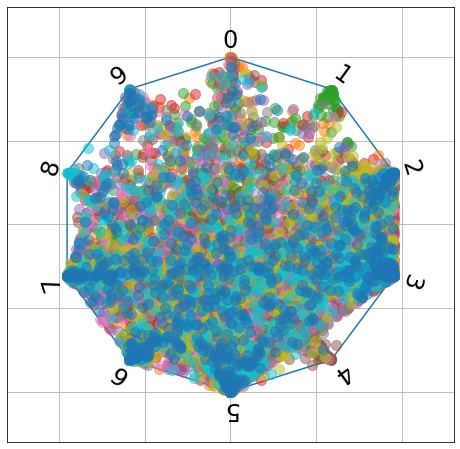

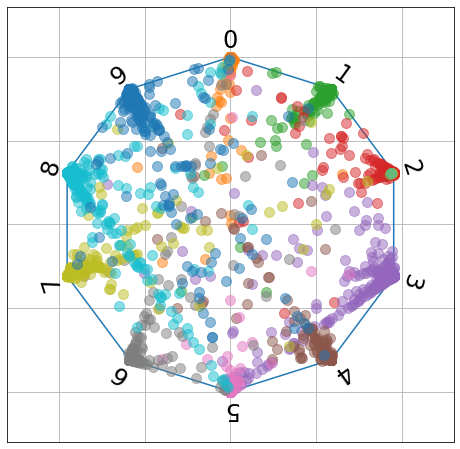

In [10]:
from utils import plot_softmax

plot_softmax(result_mlp['label'], result_mlp['softmax'], np.arange(10))

plot_softmax(result_cnn['label'], result_cnn['softmax'], np.arange(10))


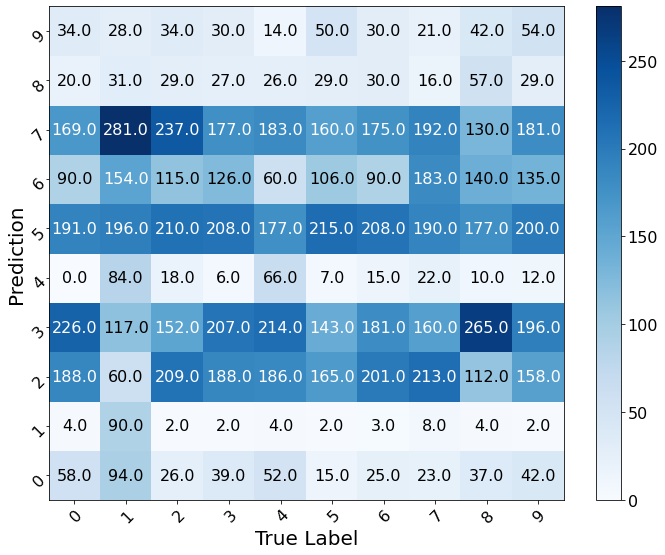

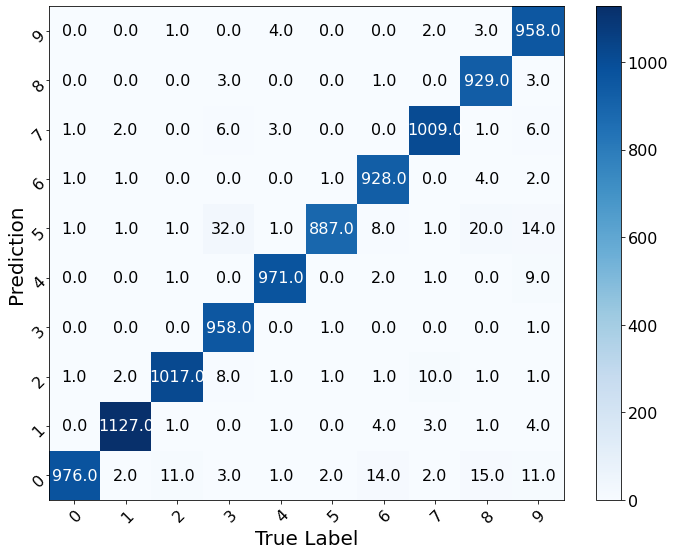

In [11]:
from utils import plot_confusion_matrix

plot_confusion_matrix(result_mlp['label'],
                      result_mlp['prediction'],
                      np.arange(10))

plot_confusion_matrix(result_cnn['label'],
                      result_cnn['prediction'],
                      np.arange(10))


## Exercise 4: repeat the study using (train,test) = (shifted,shifted)


In [ ]:
# your code

## Exercise 5: repeat the study using (train,test) = (shifted,no shift)


In [ ]:
# your code